## Background

Hey, some time passed since the last post, where I described why it's must to apply Dunnett's correction for multivariate testing.
This time I'm eager to open the topic of maturing metrics, particularly conversions, how to properly analyse the experiment with such a target, what are the options and which one is applied at HomeBuddy where we strive to squeeze maximum from every experiment. 

### Prerequisites

As usual the code snippets that are used for demo are written in Python, so to thoroughly follow the content, it's better to have some exposure to the language and its main packages, although I'm adding extensive comments, so even if you're not into programming you can grasp the pith anyway.

> *Disclaimer: The actual notebook was written on Python 3.11.4 and to keep the results reproducible here is the list of particular packages that are being used specified with their versions.*

In [ ]:
#| eval: false
pip install --quiet --upgrade numpy==1.25.2 pandas==2.0.3 scipy==1.11.2 statsmodels==0.14.0 podlozhnyy_module==2.5.3

### Data

We need more data!
This time the data simulation process is a little tricky than in case of a plain conversion as soon as we need to specify the maturation curve.

If you are not familiar with the concept of a maturation let me provide you with an example: imagine as a target in an AB experiment you have a deep conversion from a visit to a final goal, it may be an order for an arbitrary e-commerce web-site or the first payment in a mobile game.

What all these deep actions usually have in common is that they are revenue-generating events which makes them a good proxy to measure the success of the experiment, from the other flip they take time to happen, depending on the specifics of the business, this could be even days or weeks.

In the context of HomeBuddy this might be an appointment or a deal that is our north star, as this is the reaper point where both sides (lead and contractor) reached their primary goal.

In order to avoid revealing the cards, I suggest we use an arbitrary maturation curve that is not inherited from our data, however it's a pretty true-to-life example of how metric adds up to the final value.

Maturation curves are usually might be described to a very high extent with [Pareto](https://en.wikipedia.org/wiki/Pareto_distribution) distribution, which was initially developed to define a wealth's distribution in the society, however the theory underneath is going way beyond widely known Pareto 80-20 principle as in essence it's a parametric distribution that is good to define highly skewed data samples with a long heavy tail.

If you're interested in challenging your metric using the materials from the post, I suggest you give a shot to [ParetoApprox](https://github.com/NPodlozhniy/podlozhnyy-module/blob/d01847c676180537cc2f0a3279f2ae2748d1fecf/podlozhnyy_module/pareto.py#L7) function from my module that basically finds the best Pareto distribution parameters to fit the supplied array of the data, and voila you have a random variable that describes your metric and therefore you can do an infinite sampling and verify hypotheses about the applied techniques.

For this post let's stop at one specific and quite realistic distribution of the metric maturation by days.

In [1]:
#| output: false
import numpy as np
import pandas as pd

import podlozhnyy_module as pm

from tqdm.notebook import tqdm

Hey! You've successfully imported the module featured by https://github.com/NPodlozhniy
To check the entire set of methods, execute dir(podlozhnyy_module). Enjoy!


What's important is barely we can expect that all visitors finally will reach the goal and hence while those, who will, can be described with Pareto, the major part of visitors will never convert and hence the true distribution of visitors is the sampling between never converted visitors and the rest of them, whose conversion day is distributed by Pareto.

Hopefully I've already created such an "Extended" Pareto distribution and you can define a metric of such a nature right out of the box: 
[ParetoExtended](https://github.com/NPodlozhniy/podlozhnyy-module/blob/d01847c676180537cc2f0a3279f2ae2748d1fecf/podlozhnyy_module/pareto.py#L54) in addition to Pareto specific `alpha`, `loc` and `scale` params is taking `default_proba` and `default_value` which means what ultimate percentage of visitors would never convert and which particular value should I assign to them, it's an arbitrary (usually negative) number that stands on the left of X axis from the main Pareto distribution.

In [2]:
f = pm.pareto.ParetoExtended(
    alpha=1.161,
    default_value=0,
    default_proba=0.5
)

As an example here is the metric where the ultimate conversion is a half of the users (and the other half is never converted) and their conversions happen accordingly to a textbook Pareto principle 80-20

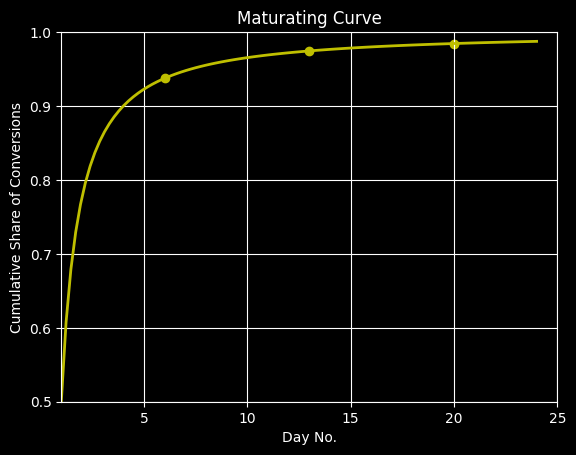

In [3]:
from matplotlib import pyplot as plt

plt.style.use('dark_background')


def plot_maturating_curve(f: pm.pareto.ParetoExtended, xmin=0, ymin=None) -> None:
    """
    Plot maturating curve for the conversion that has given distribution
    """

    xarr = np.linspace(xmin, 24, 100)
    cdf = [f.cdf(x) for x in xarr]

    weeks_x = range(6, 24, 7)
    weeks_cdf = [f.cdf(x) for x in weeks_x]

    plt.plot(xarr, cdf, 'y-', linewidth=2)
    plt.scatter(x=weeks_x, y=weeks_cdf, marker='o', s=36, c='y')

    plt.xlabel('Day No.')
    plt.ylabel('Cumulative Share of Conversions')
    plt.title('Maturating Curve')
    plt.xlim([min(xarr), max(xarr) + 1])
    plt.ylim([ymin if ymin else f._zero_p, 1.0])
    plt.grid()
    plt.show()

plot_maturating_curve(f, xmin=1)

The line start from 0.5 because it's defined with `default_proba` that only a half of users will have a conversion after all, for the half of them there will be no conversion at all, so they reach the maturatity on the first day.

In [4]:
# eval: false
sample = f.rvs(100_000)

# 80th percentile of Pareto part is 90th percentile of declared random variable
# as half of values are set to zero with default_proba
percentile80 = np.percentile(sample, 90)

print(f"20% of population possess {sum(sample[sample >= percentile80]) / sum(sample):.1%} of wealth")

20% of population possess 75.2% of wealth


So, as you can see everything works as expected, and in addition you have flexibility for sampling as non-converted users are embedded

## Power Research

The focus of the article is to explore what happens to the power of an experiment when a maturating conversion is not treated properly

### Sample Size

First of all let's set a few introductory parameters and move on to the sample's size calculation, that we have to provide in order to achieve 80% power. We explore a deep conversion, so the base value is a matter of tenths of a percent, in addition we will employ multivariate testing approach as it's usually the case.

In [5]:
from podlozhnyy_module.abtesting import ZDunnett
from statsmodels.stats.proportion import proportion_confint


CONVERSION = 0.004
N_GROUPS = 3
DURATION_DAYS = 21
USERS_PER_DAY = 10_000
EFFECT_SIZE = 0.12


from scipy.stats import norm, binom

def min_sample_size(mde: float, var: float, alpha: float=0.05, power: float=0.8):
    """
    General-purpose calculator for T-test sample size.
    As long as a variance is supplied as a prameter, 
    it can be accountant for different variations of a classical test.

    Args:
        mde: absolute value of a minimal detectable effect
        var: variance of leveraged T-statistic
        alpha: Type I error rate
        power: 1 - Type II error rate
    Returns:
        int, minimum size of each sample
    """
    effect_size = mde / var ** 0.5
    return round(2 * ((norm.ppf(1 - alpha/2) + norm.ppf(power)) / effect_size) ** 2)

For an accurate size calculation let's get a proper estimate of the variance from a simulation of a future experiment. The conversions number is considered a binomial random variable, like there is no maturity, it's equal to a size estimation on the basis of the historical value of your conversion.

In [16]:
input = dict()

input["names"] = [chr(ord("A") + i) for i in range(N_GROUPS)]
input["variant"] = input["names"][-1]

input["base"] = [DURATION_DAYS * USERS_PER_DAY] * N_GROUPS
input["target"] = [binom(n=DURATION_DAYS * USERS_PER_DAY, p=CONVERSION).rvs() for _ in range(N_GROUPS)]

test = ZDunnett(input, "base", "target", "names", "variant")

test.groups_results()

{'variant': ['B', 'C'],
 'statistic': array([-0.71881574, -0.47094824]),
 'p-value': array([0.69330407, 0.85181339])}

In [17]:
min_sample_size(mde=EFFECT_SIZE * CONVERSION, var=test.variance, alpha=0.1, power=0.8)

207983

Of course there is some variance in this variance calculation, although it's essentially enough to carry an experiment for 21 day with 10K users per day to get 80% power, given the rest of input parameters and if you wait an infinite amount of time after the sampling is finished and consequently take into account every single conversion that happens sooner or later.

### Monte-Carlo

Let's design a procedure to look at the power in case of early stopping for different time frames and as a good habit it's always better to ensure the correctness of the criterion beforehand - so will measure that FWER is controlled accordingly as well.

In [18]:
# it can by any negative number, that works just like a signal of the lack of conversion
DEFAULT = -10

It is proposed to use some arbitrary extended Pareto distribution, that has a few characteristics
 - 75% of conversions happen during the first week
 - 90% of conversions happen within 3 weeks
 - in total percentage of conversions is equal to `CONVERSION`

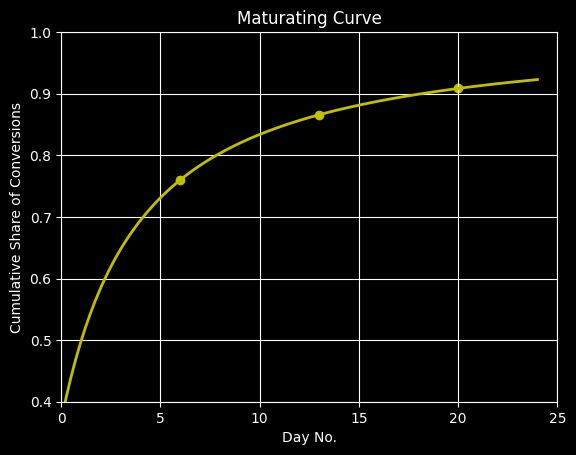

76% of conversions happen during 1 week
87% of conversions happen during 2 weeks
91% of conversions happen during 3 weeks


In [19]:
def distribution(conv_proba: float) -> pm.pareto.ParetoExtended:
    """
    Returns a possible distribution of a maturating metric

    Args:
        conv_proba: ultimate share of conversions
        equals to: 1 - the share of users who will not convert
    """
    return pm.pareto.ParetoExtended(
        alpha=1.136,
        loc=-4.475,
        scale=2.981,
        default_value=DEFAULT,
        default_proba=1-conv_proba,
    )

f = distribution(1.0)

plot_maturating_curve(f, xmin=0, ymin=0.4)

for idx, val in enumerate([f.cdf(x) for x in range(6, 22, 7)]):

    print(f"{val:.0%} of conversions happen during {1 + idx} week{'s' if idx > 0 else ''}")

In addition we need a sample generator that would count the conversions that happen only before we draw a conclusion. Method `generate_sample` would vary throughout the notebook: the first implementation reflects the idea of drawing a conclusion right after we stopped the experiment.

As usual Monte-Carlo process comes handy when you want to carry some "meta" experiments. 
Simplifying the code, Monte Carlo procedure is wrapped into a function with all the necessary parameters supplied as arguments.

In [21]:
def generate_sample(
    conv_proba: float,
    exp_duration: int,
    users_per_day: int,
) -> int:
    """
    Build a sample of bernoulli random variable where
    1 = conversion happened during the time of an experiment
    0 = conversion wouldn't happen at all or only after we stopped and draw a conclusion
    The output is the sum of the sample = total number of conversions

    Args:
        conv_proba: ultimate share of conversions
        exp_duration: experiment duration (days)
        users_per_day: number of users received per day
    Returns:
        int: number of registered conversions
    """

    rv = distribution(conv_proba)
    conversions = 0

    for day in range(exp_duration):

        data = rv.rvs(users_per_day)
        conversions += sum((data > DEFAULT) & (data <= day))

    return conversions


def monte_carlo(
    aa_test: bool = True,
    verbose: bool = True,
    n_iterations: int = 1_000,
    exp_duration: int = DURATION_DAYS,
    users_per_day: int = USERS_PER_DAY,
    p_general: float = CONVERSION,
    n_groups: int = N_GROUPS,
    effect_size: float = EFFECT_SIZE,
    alpha: float = 0.10,
    **kwargs,
) -> tuple:

    input = dict.fromkeys(["base", "target", "names", "variant"])
    input["names"] = [chr(ord("A") + i) for i in range(n_groups)]
    input["variant"] = input["names"][-1]

    dunnett_positives = 0
    z_positives = 0

    for i in range(n_iterations):

        input["base"] = [exp_duration * users_per_day] * n_groups
        input["target"] = [
            generate_sample(
                p_general,
                exp_duration,
                users_per_day,
                **kwargs
            ) for _ in range(n_groups - 1)
        ]
        input["target"] += [
            generate_sample(
                p_general * (1 + effect_size * (1 - aa_test)),
                exp_duration,
                users_per_day,
                **kwargs
            )
        ]

        dunnett_test = ZDunnett(input, "base", "target", "names", "variant")

        dunnett_p_value = dunnett_test.groups_results(alternative="two-sided")["p-value"]

        if aa_test:
            if max(dunnett_p_value <= alpha):
                dunnett_positives += 1
        else:
            if isinstance(dunnett_p_value, np.ndarray) and dunnett_p_value[-1] <= alpha:
                dunnett_positives += 1
            elif isinstance(dunnett_p_value, np.float64) and dunnett_p_value <= alpha:
                dunnett_positives += 1
            
    dl, dr = proportion_confint(count=dunnett_positives, nobs=n_iterations, alpha=0.10, method='wilson')

    if verbose:
        buffer_window = kwargs.get("extra_waiting_days")
        baking_window = kwargs.get("baking_window")
        print (
            f"{'FPR ' if aa_test else f'TPR of {effect_size:.0%} effect size {chr(10)}'}"
            f"for {exp_duration}-day's experiment"
            f"{f'{chr(10)}with {buffer_window} buffer days in the end' if buffer_window else ''}"
            f"{f'{chr(10)}with baking window of {baking_window} days' if baking_window else ''}"
            f"{chr(10)}where {users_per_day:,} users are exposed per day:{chr(10)}"
            f" {dunnett_positives / n_iterations:.3f} ± {(dr - dl) / 2:.3f}"
        )
    return [dl, dunnett_positives / n_iterations, dr]

### Correctness

It's never an excess to double check that the criterion that is used works as expected. 

In [22]:
%%time
np.random.seed(2024)
_ = monte_carlo()

FPR for 21-day's experiment
where 10,000 users are exposed per day:
 0.101 ± 0.016
CPU times: total: 8min
Wall time: 8min 5s


Alpha is way between the bounds for Type I error rate, so we're free to go ahead.

### Power

In case of no pause after the latest visitor exposure - the power falls off to 60%, just a reminder that it supposed to be 80%, insane!

In [23]:
%%time
np.random.seed(2024)
_ = monte_carlo(aa_test=False)

TPR of 12% effect size 
for 21-day's experiment
where 10,000 users are exposed per day:
 0.568 ± 0.026
CPU times: total: 7min 29s
Wall time: 7min 32s


Let's explore what happens to the power if we are not in a hurry with conclusions.

In [24]:
def generate_sample(
    conv_proba: float,
    exp_duration: int,
    users_per_day: int,
    extra_waiting_days: int,
) -> int:
    """
    Extra Args:
        extra_waiting_days: how many days we wait until drawing a conclusion
    """

    rv = distribution(conv_proba)
    conversions = 0

    for day in range(exp_duration):

        data = rv.rvs(users_per_day)
        conversions += sum((data > DEFAULT) & (data <= day + extra_waiting_days))

    return conversions

A new way to generate a sample provides and extra opportunity to select how many days we're ready to wait until the experiment is finished. 
Be careful as the code below takes time!

In [25]:
%%time
np.random.seed(2024)

power_with_waiting = []

for to_wait_for in tqdm(range(1, 22, 2)):
    result = monte_carlo(aa_test=False, verbose=False, extra_waiting_days=to_wait_for)
    power_with_waiting.append(result)

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: total: 1h 17min 19s
Wall time: 1h 17min 40s


In [26]:
%%time
np.random.seed(2024)

power_with_waiting_4weeks = []

for to_wait_for in tqdm(range(1, 22, 2)):
    result = monte_carlo(aa_test=False, verbose=False, exp_duration=28, effect_size=0.10, extra_waiting_days=to_wait_for)
    power_with_waiting_4weeks.append(result)

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: total: 1h 37min 48s
Wall time: 1h 37min 56s


The chart makes it clear how important it is - not to rush with conclusions, in parenthesis, in everyday life it works exactly the same! 
We lose about 10 percentage points of the power if we are not ready to wait yet another week.

In [ ]:
#| eval: false
import plotly.express as px
import plotly.graph_objs as go

def hex2rgba(hex, alpha):
    """
    Convert plotly hex colors to rgb and enables transparency adjustment
    """
    col_hex = hex.lstrip('#')
    col_rgb = tuple(int(col_hex[i : i + 2], 16) for i in (0, 2, 4))
    col_rgb += (alpha,)
    return 'rgba' + str(col_rgb)

def get_new_color(colors):
    while True:
        for color in colors:
            yield color

colors_list = px.colors.qualitative.Plotly
rgba_colors = [hex2rgba(color, alpha=0.5) for color in colors_list]
palette = get_new_color(rgba_colors)

def add_chart(figure, data, title=None, showtitle=False):

    x = list(range(1, 22, 2))
    color = next(palette)
    
    figure.add_trace(
        go.Scatter(
            name=title if title else "Point Estimate",
            x=x,
            y=[v[1] for v in data],
            mode='lines',
            line=dict(color=color),
            showlegend=showtitle,
        ),
    )
    figure.add_trace(
        go.Scatter(
            name='Upper Bound',
            x=x,
            y=[v[2] for v in data],
            mode='lines',
            line=dict(width=0),
            marker=dict(color="#444"),
            hovertemplate="%{y:.3f}",
            showlegend=False,
        ),
    )
    figure.add_trace(
        go.Scatter(
            name='Lower Bound',
            x=x,
            y=[v[0] for v in data],
            mode='lines',
            line=dict(width=0),
            marker=dict(color="#444"),            
            hovertemplate="%{y:.3f}",
            showlegend=False,
            fillcolor=color,
            fill='tonexty',
        ),
    )


figure = go.Figure()

add_chart(figure, power_with_waiting)

figure.update_xaxes(
    title_text="Days passed since the exposure was stopped until a conclusion was made"
)

figure.update_layout(
    yaxis_title='True Positive Rate',
    title={
        "x": 0.5,
        "text": 'Power of criterion',
    },
    hovermode="x",
    template="plotly_dark",
)

figure.show()

In [28]:
#| echo: false
figure.write_json("power-dynamic-with-waiting.json")

Essentially, it's a mediocre example, when it comes to the real experiments we usually have more hidden variables that impact metrics maturation: working days and hours, holidays, etc.
To show you the dependency on the day of the week let me add a basic weekly seasonality.
In simple words a delay to maturation of the metric during the weekend is added, that applies a sense of a business process that can't be done on a weekend so conversion happens only during the working week.
Of course it's intensely simplified example that only takes into account the first week of the maturation and doesn't account for users variation per day, the result speaks for itself though.

In [29]:
def generate_sample(
    conv_proba: float,
    exp_duration: int,
    users_per_day: int,
    extra_waiting_days: int,
    weekday_exp_start: int,
) -> int:
    """
    Extra Args:
        weekday_exp_start: number of a weekday in ISO format
        From 1 through 7, where Monday = 1 and so on
    """

    rv = distribution(conv_proba)
    conversions = 0

    for day in range(exp_duration):
        data = rv.rvs(users_per_day)
        if weekday_exp_start and (weekday_exp_start + day) % 6 == 0:
            conversions += sum((data > DEFAULT) & (data + 2 <= day + extra_waiting_days))
        elif weekday_exp_start and (weekday_exp_start + day) % 7 == 0:
            conversions += sum((data > DEFAULT) & (data + 1 <= day + extra_waiting_days))
        else:
            conversions += sum((data > DEFAULT) & (data <= day + extra_waiting_days))

    return conversions

As a rule of thumb the experiments are run during the working week only and are analyzed during the working week, usually if one was run on the night from Monday to Tuesday it will be stopped on the corresponding night a few weeks later and analyzed on the next day.
I suggest we reproducing this set up and assume we draw a conclusion at the next day after stopping (for simplicity you can imagine that we run all experiments at midnight).
How the power of an experiment depends on a day of the week when it was run?

In [30]:
%%time
np.random.seed(2024)

weekday_power = []

for day_of_week in tqdm(range(1, 6)):
    result = monte_carlo(aa_test=False, verbose=False, extra_waiting_days=0, weekday_exp_start=day_of_week)
    weekday_power.append(result)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 33min 27s
Wall time: 33min 28s


In [ ]:
#| eval: false

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    name='TPR',
    x=['Mon', 'Tue', 'Wed', 'Thu', 'Fri'],
    y=[v[1] for v in weekday_power],
    marker_color=next(palette),
    error_y=dict(type='data', array=[round(v[1] - v[0], 3) for v in weekday_power]),
))

fig.update_layout(
    yaxis_title='True Positive Rate',
    title={
        "x": 0.5,
        "text": 'Power of criterion',
    },
    hovermode="x",
    template="plotly_dark",
)

fig.show()

In [55]:
#| echo: false
fig.write_json("power-by-weekdays.json")

As expected, worst day of the week scenario is Monday, interesting what happens to the power if we're ready to wait with analysis for an extra week until the next Monday?

In [33]:
np.random.seed(2024)
_ = monte_carlo(aa_test=False, extra_waiting_days=7, weekday_exp_start=1)

TPR of 12% effect size 
for 21-day's experiment
with 7 buffer days in the end
where 10,000 users are exposed per day:
 0.623 ± 0.025


It improves the power and levels the weekday effect out; it's what I suggest you take away: any extra dependency complicates the process and may decrease the power, although to wait for an extra week to let the metric reach its maturation appears to be a solution anyway.

### Baking Window

Often it's suggested to use a baking window concept: so to register a conversion during the defined time frame respectively for every cohort, it's a viable option and always a go-to technique. 
Let's compare such a "cohort based" approach power against the basis "count everything that's converted so far".

In [34]:
def generate_sample(
    conv_proba: float,
    exp_duration: int,
    users_per_day: int,
    baking_window: int,
) -> int:
    """
    Extra Args:
        baking_window: only count a conversion if it happens during this number of days
    """

    rv = distribution(conv_proba)
    data = rv.rvs(users_per_day * exp_duration)
    conversions = sum((data > DEFAULT) & (data < baking_window))

    return conversions

We need to recalculate sample size as it would be different because now the ultimate conversion is lower, we only take into account specific time frame for every cohort. 

In [35]:
input = dict()

input["names"] = [chr(ord("A") + i) for i in range(N_GROUPS)]
input["variant"] = input["names"][-1]

input["base"] = [DURATION_DAYS * USERS_PER_DAY] * N_GROUPS
input["target"] = [generate_sample(CONVERSION, DURATION_DAYS, USERS_PER_DAY, baking_window=7) for _ in range(N_GROUPS)]

test = ZDunnett(input, "base", "target", "names", "variant")

test.groups_results()

{'variant': ['B', 'C'],
 'statistic': array([0.77838058, 0.30579237]),
 'p-value': array([0.65239556, 0.93402278])}

In [36]:
min_sample_size(mde=EFFECT_SIZE * np.mean(test.p_samples / test.n_samples), var=test.variance)

344708

As you can see more days of sampling are required for this technique, followed by those after the end of experiment when we wait for a convergence of a conversion.

In [37]:
np.random.seed(2024)
_ = monte_carlo(aa_test=False, baking_window=7)

TPR of 12% effect size 
for 21-day's experiment
with baking window of 7 days
where 10,000 users are exposed per day:
 0.594 ± 0.026


If no more days provided - then the power is rather low, although for more extensive experiment it's mush higher.

In [38]:
np.random.seed(2024)
_ = monte_carlo(aa_test=False, exp_duration=28, baking_window=7)

TPR of 12% effect size 
for 28-day's experiment
with baking window of 7 days
where 10,000 users are exposed per day:
 0.712 ± 0.024


So, it's interesting which strategy outperforms another one, so let's make a comparison for different time spans. 
 - the first one it's just how many days we wait until the end of experiment before the analysis
 - with the second one in addition baking window is applied, so we only count a conversion within a specific window that is exact same width like the break after the end of the experiment

In [39]:
%%time
np.random.seed(2024)

power_baking_window = []

for to_wait_for in tqdm(range(1, 22, 2)):
    result = monte_carlo(aa_test=False, verbose=False, baking_window=to_wait_for)
    power_baking_window.append(result)

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: total: 1h 16min 21s
Wall time: 1h 16min 40s


In [ ]:
#| eval: false
figure = go.Figure()

add_chart(figure, power_with_waiting, title="w/o baking window", showtitle=True)
add_chart(figure, power_baking_window, title="with baking window", showtitle=True)

figure.update_xaxes(
    title_text="Days passed since the exposure was stopped (doubles up as baking window width)"
)

figure.update_layout(
    yaxis_title='True Positive Rate',
    title={
        "x": 0.5,
        "text": 'Power of criterion (3 weeks experiment)',
    },
    hovermode="x",
    template="plotly_dark",
)

figure.show()

In [75]:
#| echo: false
figure.write_json("power-comparison-baking-window.json")

So, for the analyzed set up it's obvious that the basic approach is a winner and uniformly no less powerful. 
It provides a higher power by a wide margin if you wait just a few days after the experiment while if you have a forbearance to wait longer the difference is not significant.

In [42]:
%%time
np.random.seed(2024)

power_baking_window_4weeks = []

for to_wait_for in tqdm(range(1, 22, 2)):
    result = monte_carlo(aa_test=False, verbose=False, exp_duration=28, effect_size=0.10, baking_window=to_wait_for)
    power_baking_window_4weeks.append(result)

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: total: 1h 43min 17s
Wall time: 1h 43min 22s


One last thing that is important to be mentioned is how this tendency is affected by a duration of an experiment. 
It's quite obvious that the longer experiment takes the less significant will be an effect of waiting (under the conditions of the same target metric maturation curve). 
Here is the comparison similar to one above but for 4-weeks experiment with a little less effect size, so it shall show close power numbers. 

In [ ]:
#| eval: false
figure = go.Figure()

add_chart(figure, power_with_waiting_4weeks, title="w/o baking window", showtitle=True)
add_chart(figure, power_baking_window_4weeks, title="with baking window", showtitle=True)

figure.update_xaxes(
    title_text="Days passed since the exposure was stopped (doubles up as baking window width)"
)

figure.update_layout(
    yaxis_title='True Positive Rate',
    title={
        "x": 0.5,
        "text": 'Power of Сriterion (4 weeks experiment)',
    },
    hovermode="x",
    template="plotly_dark",
)

figure.show()

In [77]:
#| echo: false
figure.write_json("power-comparison-baking-window-4weeks.json")

So, two observations:
 - it seems that no matter what is the experiment's duration the strategy where all events are counted works better in case of a short baking window 
 - waiting at least for a week after the experiment is over for more conversions to happen is must for short experiments only

## Conclusion

Now you know, how important it's to give your metric time to mature and don't rush with the conclusions for "gray" experiments, even if you didn't reach statistically significant result immediately after you stopped the exposure to the experiment, it doesn't mean that you would finally get it a little later.

The effect is especially great for the shorter experiments, within your data specific the time frames may strongly vary although this rule is an invariant, the longer you run it the less power you lose when drawing a conclusion right after the experiment's finish. However it totally makes sense to give some time to the recent users to have their conversions if you want to take them into account in the same way as those who came earlier, otherwise the latest users performance is neglected and the conclusion relies on those who came earlier mostly.

The final thought is that not every time well-known techniques fits your personal set up, in our case it was easy to show that movement to a baking window can only either (or even both simultaneously) drop the power down or push the experiment duration up, so the simpler default approach works uniformly better.